<a href="https://colab.research.google.com/github/prikshit-2000/Tensorflow/blob/main/CAM_Dogs_vs_Cats.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [7]:
import numpy as np
import scipy
import tensorflow as tf
import PIL
from tensorflow.keras.layers import Dense,Conv2D,Flatten,GlobalAveragePooling2D,MaxPooling2D
from tensorflow.keras.utils import plot_model
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential,Model
import cv2


In [3]:
train_data = tfds.load('cats_vs_dogs' , split = 'train[:80%]',as_supervised=True)
validation_data = tfds.load('cats_vs_dogs',split = 'train[80%:90%]' , as_supervised= True)
test_data = tfds.load('cats_vs_dogs' , split = 'train[-10%:]',as_supervised=True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/cats_vs_dogs/4.0.0.incompleteAJOPJ9/cats_vs_dogs-train.tfrecord


  0%|          | 0/23262 [00:00<?, ? examples/s]

Dataset cats_vs_dogs downloaded and prepared to /root/tensorflow_datasets/cats_vs_dogs/4.0.0. Subsequent calls will reuse this data.


In [5]:
def augment_images(image,label):
    image = tf.cast(image , tf.float32)

    image = (image/255)
    image = tf.image.resize(image  , (300,300))
    return image,label

augmented_training_data  = train_data.map(augment_images)
train_batches = augmented_training_data.shuffle(1024).batch(32)



In [8]:
model = Sequential()
model.add(Conv2D(16,input_shape=(300,300,3),kernel_size=(3,3),activation='relu',padding='same'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(32,kernel_size=(3,3),activation='relu',padding='same'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(64,kernel_size=(3,3),activation='relu',padding='same'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(128,kernel_size=(3,3),activation='relu',padding='same'))
model.add(GlobalAveragePooling2D())
model.add(Dense(1,activation='sigmoid'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 300, 300, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 150, 150, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 150, 150, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 75, 75, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 75, 75, 64)        18496     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 37, 37, 64)       0

In [9]:
model.compile(loss = 'binary_crossentropy' , metrics = ['accuracy'] , optimizer = 'adam')

In [11]:
model.fit(train_batches , epochs = 5)

Epoch 1/5
582/582 [==============================] - 134s 172ms/step - loss: 0.6735 - accuracy: 0.5593
Epoch 2/5
582/582 [==============================] - 100s 167ms/step - loss: 0.6488 - accuracy: 0.6050
Epoch 3/5
582/582 [==============================] - 104s 174ms/step - loss: 0.6116 - accuracy: 0.6606
Epoch 4/5
582/582 [==============================] - 105s 176ms/step - loss: 0.5803 - accuracy: 0.6969
Epoch 5/5
582/582 [==============================] - 103s 174ms/step - loss: 0.5559 - accuracy: 0.7161


In [17]:
gap_weights = model.layers[-1].get_weights()[0]
cam_model = Model(inputs = model.input , outputs =  (model.layers[-3].output,  model.layers[-1].output))
cam_model.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_input (InputLayer)   [(None, 300, 300, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 300, 300, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 150, 150, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 150, 150, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 75, 75, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 75, 75, 64)        1849

In [18]:
def show_cam(image_value , features,results):
    features_for_img = features[0]
    prediction   = results[0]

    class_activation_weights = gap_weights[:,0]
    class_activation_features = scipy.ndimage.zoom(features_for_img,
                                                   (300/37,300/37,1) ,order = 2)
    cam_output = np.dot(class_activation_features,class_activation_weights)
    print(f'sigmoid output: {results}')
    print(f"prediction : {'dog' if round(results[0][0]) else 'cat'}")
    plt.figure(figsize = (8,8))
    plt.imshow(cam_output , cmap = 'jet',alpha = 0.5)
    plt.imshow(tf.squeeze(image_value),alpha = 0.5)
    plt.show()

In [19]:
!wget -O cat1.jpg https://storage.googleapis.com/laurencemoroney-blog.appspot.com/MLColabImages/cat1.jpg
!wget -O cat2.jpg https://storage.googleapis.com/laurencemoroney-blog.appspot.com/MLColabImages/cat2.jpg
!wget -O catanddog.jpg https://storage.googleapis.com/laurencemoroney-blog.appspot.com/MLColabImages/catanddog.jpg
!wget -O dog1.jpg https://storage.googleapis.com/laurencemoroney-blog.appspot.com/MLColabImages/dog1.jpg
!wget -O dog2.jpg https://storage.googleapis.com/laurencemoroney-blog.appspot.com/MLColabImages/dog2.jpg

--2021-11-22 06:10:36--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/MLColabImages/cat1.jpg
Resolving storage.googleapis.com (storage.googleapis.com)... 172.217.214.128, 172.253.119.128, 108.177.111.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|172.217.214.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 414826 (405K) [image/jpeg]
Saving to: ‘cat1.jpg’

cat1.jpg            100%[===================>] 405.10K  --.-KB/s    in 0.004s  

2021-11-22 06:10:36 (88.8 MB/s) - ‘cat1.jpg’ saved [414826/414826]

--2021-11-22 06:10:36--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/MLColabImages/cat2.jpg
Resolving storage.googleapis.com (storage.googleapis.com)... 209.85.200.128, 108.177.112.128, 74.125.124.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|209.85.200.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 599639 (586K) [image/jpeg]
Saving to: ‘cat2.

sigmoid output: [[0.33003274]]
prediction : cat


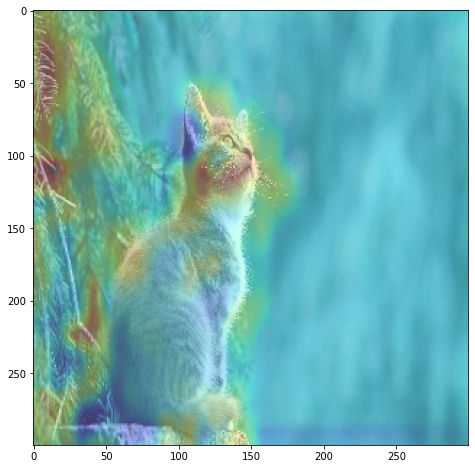

sigmoid output: [[0.4638752]]
prediction : cat


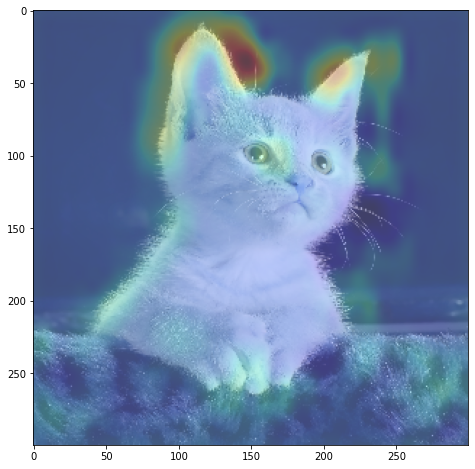

sigmoid output: [[0.30049083]]
prediction : cat


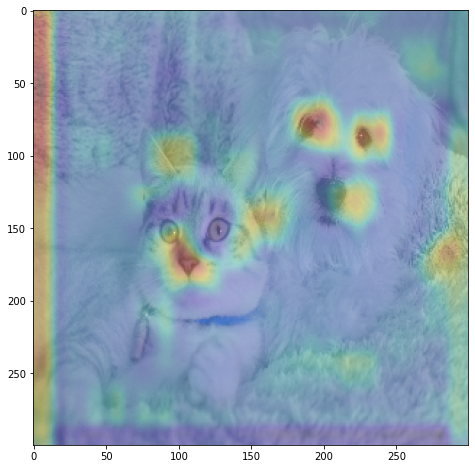

sigmoid output: [[0.1479062]]
prediction : cat


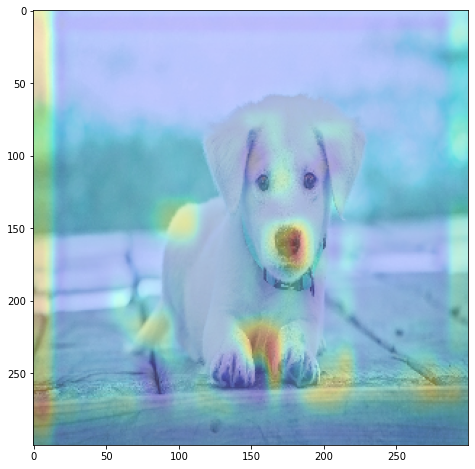

sigmoid output: [[0.6271111]]
prediction : dog


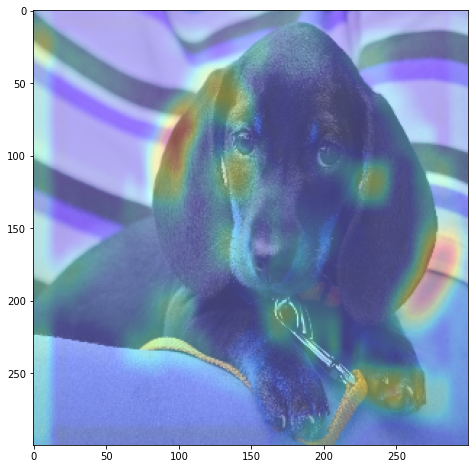

In [20]:
# utility function to preprocess an image and show the CAM
def convert_and_classify(image):

  # load the image
  img = cv2.imread(image)

  # preprocess the image before feeding it to the model
  img = cv2.resize(img, (300,300)) / 255.0

  # add a batch dimension because the model expects it
  tensor_image = np.expand_dims(img, axis=0)

  # get the features and prediction
  features,results = cam_model.predict(tensor_image)
  
  # generate the CAM
  show_cam(tensor_image, features, results)

convert_and_classify('cat1.jpg')
convert_and_classify('cat2.jpg')
convert_and_classify('catanddog.jpg')
convert_and_classify('dog1.jpg')
convert_and_classify('dog2.jpg')

ground truth: cat
sigmoid output: [[0.25926757]]
prediction : cat


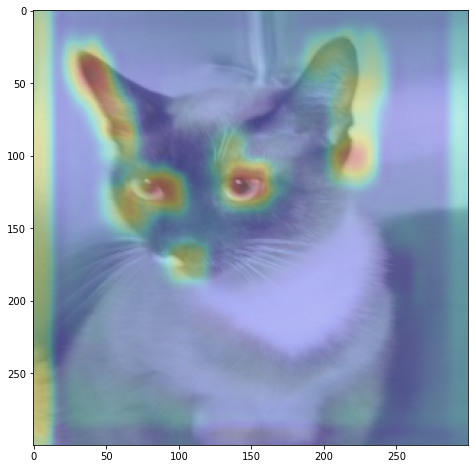

ground truth: dog
sigmoid output: [[0.27551606]]
prediction : cat


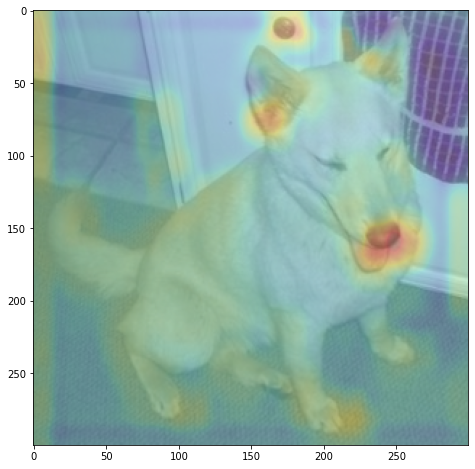

ground truth: dog
sigmoid output: [[0.19089283]]
prediction : cat


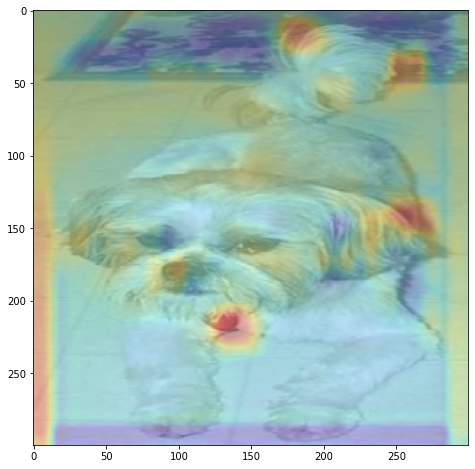

ground truth: cat
sigmoid output: [[0.3290383]]
prediction : cat


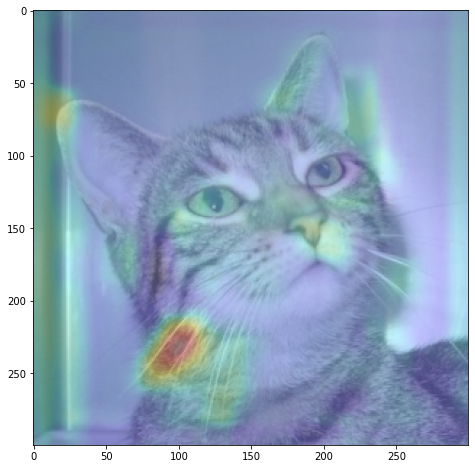

ground truth: cat
sigmoid output: [[0.2506466]]
prediction : cat


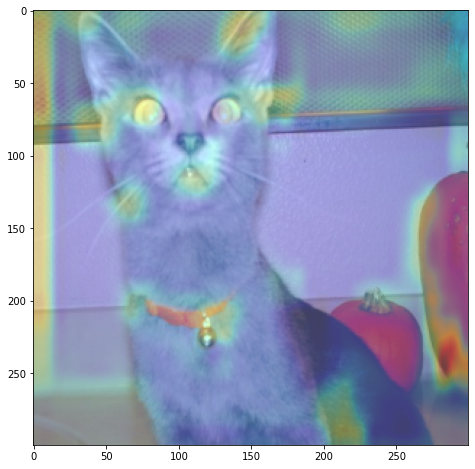

In [21]:
# preprocess the test images
augmented_test_data = test_data.map(augment_images)
test_batches = augmented_test_data.batch(1)


for img, lbl in test_batches.take(5):
  print(f"ground truth: {'dog' if lbl else 'cat'}")
  features,results = cam_model.predict(img)
  show_cam(img, features, results)